# Insert Title Here

## Imports

Basic Libraries

- [`numpy`](https://numpy.org) contains a large collection of mathematical functions
- [`pandas`](https://pandas.pydata.org) contains functions that are designed for data manipulation and data analysis

In [1]:
import numpy as np
import pandas as pd

Visualization Libraries

- [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/afm_api.html) contains functions to create interactive plots
- [`seaborn`](https://seaborn.pydata.org/index.html) is a library based on matplotlib that allows for data visualization
- [`spacy`](https://spacy.io) is a Python-based open-source library used in processing text data.
- [`wordcloud`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) contains functions for generating wordclouds from text data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

[`Natural Language Processing`](https://www.nltk.org/index.html) Libraries

- [`re`](https://www.nltk.org/api/nltk.chunk.regexp.html?highlight=import+re) is a module that allows the use of regular expressions
- [`nltk`](https://www.nltk.org/install.html?highlight=import+re) contains various tools and modules for natural language processing.
- [`stopwords`](https://www.nltk.org/howto/corpus.html?highlight=stopwords)  is a corpus from NLTK, which contains common words that are often removed during text processing as they don't carry significant meaning
- [`WordNetLemmatizer()`](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnetlemmatizer) is used for word lemmatization (converting words to their base or dictionary form).
- [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.regexp.html) class from nltk, which is used for tokenizing text based on regular expressions.
- [`wordpunct_tokenize`](https://www.nltk.org/api/nltk.tokenize.wordpunct_tokenize.html?highlight=wordpunct_tokenize#nltk.tokenize.wordpunct_tokenize) function from nltk, which is used for tokenizing text into words.
- [`FreqDist`](https://www.nltk.org/api/nltk.probability.FreqDist.html?highlight=freqdist)[`FreqDist class`] from nltk.probability, which is used to compute the frequency distribution of words in a text.
- [`SentimentIntensityAnalyzer`](https://www.nltk.org/api/nltk.sentiment.SentimentIntensityAnalyzer.html?highlight=sentimentintensityanalyzer#nltk.sentiment.SentimentIntensityAnalyzer) class from nltk.sentiment, which is used for sentiment analysis of text.
-  [`ngrams`](https://www.nltk.org/api/nltk.util.html?highlight=ngrams#nltk.util.ngrams)function from nltk, which is used for generating n-grams (contiguous sequences of n words) from text.

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import wordpunct_tokenize
from nltk import download, classify, corpus
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import ngrams

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('words')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to /Users/admin/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [5]:
from collections import Counter
import string

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

# Dataset Files

The following .csv files will be used in this project:

- rap_dataframe.csv = contains the content of the articles, author, and link that is scraped from the Rappler website.
- gma_dataframe.csv and gma-10000.csv = contains the content of the articles, author, and link that is scraped from the GMA website.
- fake_or_real_news.csv = contains the content of the article and the two label namely REAL and FAKE. Retrieved from "Fake or Real News" in Kaggle
- fake news dataset.csv =  similar to fake_or_real_news.csv but its two label is numbered

## Data Collection

After importing all the necessary libraries that we would need, the next thing we would need to do is import the different .csv files from different sources into the notebook using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). After this, the head function will also be used to check the first few rows of the dataset. This will let us have a glance on the features of each dataset and what type of data each feature has.

## Importing News Sites Data

For our News Sites Data (the real news data), we have scraped two news data from the Rappler website and GMA website.

### Rappler Data

First is the Rappler Data, which will be loaded using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) and stored into a DataFrame named df_Rappler.

In [7]:
df_Rappler = pd.read_csv('/Users/admin/Desktop/FakeNews/rap_dataframe.csv')
df_Rappler.head()

,Link,Author,Content
0,https://www.rappler.com/life-and-style/literat...,[],"MANILA, Philippines – Finally! Best-selling Ja..."
1,https://www.rappler.com/nation/new-findings-ki...,['JAIRO BOLLEDO'],"MANILA, Philippines – The results of the lates..."
2,https://www.rappler.com/sports/football/tom-br...,[],Tom Brady was the ultimate winner on the field...
3,https://www.rappler.com/life-and-style/health-...,[],It’s one thing to know what makes people happy...
4,https://www.rappler.com/entertainment/music/ju...,[],Justin Bieber is the latest artist in a growin...


### GMA Data

For our GMA Data, we scraped two data. These two data will also be loaded using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html), and stored into DataFrames separately that we will be naming df_gma1 and df_gma2.

In [8]:
df_gma1 = pd.read_csv('/Users/admin/Downloads/gma-10000.csv')
df_gma1.head()

,Unnamed: 0,Link,Author,Content
0,0,https://www.gmanetwork.com/news/balitambayan/p...,[],Arestado ng Laguna Police ang isang elementary...
1,1,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],A barangay kagawad was shot dead in front of b...
2,2,https://www.gmanetwork.com/news/topstories/wor...,[],"GENEVA, Switzerland - Taliban restrictions on ..."
3,3,https://www.gmanetwork.com/news/topstories/nat...,['By GMA Integrated News'],The National Privacy Commission (NPC) has issu...
4,4,https://www.gmanetwork.com/news/topstories/wor...,[],"STOCKHOLM, Sweden - More than 600 young people..."


In [9]:
df_gma2 = pd.read_csv('/Users/admin/Downloads/gma_dataframe.csv')
df_gma2.head()

,Link,Author,Content
0,https://www.gmanetwork.com/news/topstories/wor...,[],BEIJING - China lashed out at the United State...
1,https://www.gmanetwork.com/news/topstories/met...,['By GMA Integrated News'],"Two people were arrested in Tondo, Manila for ..."
2,https://www.gmanetwork.com/news/topstories/nat...,"['By JOVILAND RITA, GMA Integrated News']",Former Bureau of Corrections (BuCor) chief Ger...
3,https://www.gmanetwork.com/news/balitambayan/b...,[],"Dalawa katao ang arestado sa Tondo, Maynila da..."
4,https://www.gmanetwork.com/news/balitambayan/p...,[],"NEW YORK CITY — Nasa 9,000 nurse na nagtatraba..."


After loading and storing it into two separate DataFrames, we will now be merging it together into one single DataFrame using [`concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat).

In [10]:
df_GMA = pd.concat([df_gma1,df_gma2], ignore_index=True)
df_GMA

,Unnamed: 0,Link,Author,Content
0,0.0,https://www.gmanetwork.com/news/balitambayan/p...,[],Arestado ng Laguna Police ang isang elementary...
1,1.0,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],A barangay kagawad was shot dead in front of b...
2,2.0,https://www.gmanetwork.com/news/topstories/wor...,[],"GENEVA, Switzerland - Taliban restrictions on ..."
3,3.0,https://www.gmanetwork.com/news/topstories/nat...,['By GMA Integrated News'],The National Privacy Commission (NPC) has issu...
4,4.0,https://www.gmanetwork.com/news/topstories/wor...,[],"STOCKHOLM, Sweden - More than 600 young people..."
...,...,...,...,...
16001,NaN,https://www.gmanetwork.com/news/topstories/wor...,"['By SOO-HYANG CHOI, Reuters']",SEOUL - North Korea said on Sunday it had test...
16002,NaN,https://www.gmanetwork.com/news/topstories/wor...,[],Former US President Jimmy Carter has decided t...
16003,NaN,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],The search for the Cessna plane which went mis...
16004,NaN,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],The search and rescue operations for the missi...


## Importing Fake News Data

Just like what we did in our first two data, we will also load the two Fake News Data that we have scraped using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html), and stored into separate DataFrames, df_fakenews1, and df_fakenews2. 

The 'article' column in df_fakenews1 will be renamed as 'Content' using the [`rename()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html?highlight=rename#pandas.DataFrame.rename), so that it would match the column name of the News Sites Data which contains the article news.

In [11]:
df_fakenews1 = pd.read_csv('/Users/admin/Desktop/FakeNews/fake news dataset.csv')
df_fakenews1.rename(columns={'article': 'Content'}, inplace=True) #renamed column
df_fakenews1.head()

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


Similarly, in df_fakenews2, the 'text' column is renamed to 'Content'. 

In [12]:
df_fakenews2 = pd.read_csv('/Users/admin/Desktop/FakeNews/fake_or_real_news.csv')
df_fakenews2 = df_fakenews2.rename(columns={'text': 'Content'}) #renamed column
df_fakenews2.head()

,Unnamed: 0,title,Content,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


As it can be seen in df_fakenews2, its 'label' column doesn't have the numerical value like what we see in the 'label' column of df_fakenews1. With that, we will be raplacing the existing values 'REAL' and 'FAKE' with 0 and 1, respectively, using the [`replace()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace).

In [13]:
#assigning new values (raplacing the existing values 'REAL' and 'FAKE' with 0 and 1, respectively in the 'label' column)
df_fakenews2['label'] = df_fakenews2['label'].replace({'REAL': 0, 'FAKE': 1})
df_fakenews2.head()

,Unnamed: 0,title,Content,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


After that, we will be replacing 0 with 1, and 1 with 0. So, it would turn out that those rows that has a value of 1 will signify a label of FAKE, while those that has a value of 0 will signify a label of REAL. The reason for this is that the News Sites Data doesn't have a 'label' column. So that, when all the data will be merged all together later on, the rows of the News Sites Data will have a 0 value in the 'label' column signifying that it is a REAL news.

In [14]:
df_fakenews2['label'] = df_fakenews2['label'].replace({0: 1, 1: 0})
df_fakenews2.head()

,Unnamed: 0,title,Content,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


After that, the two separate DataFrames then is merged together, df_fakenews1 and df_fakenews2, using [`concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat)into a single DataFrame called df_FakeNews.

In [15]:
#combining two dataset into a single DataFrame
df_FakeNews = pd.concat([df_fakenews1, df_fakenews2], ignore_index=True)
df_FakeNews

,label,Content,Unnamed: 0,title
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",NaN,NaN
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,NaN,NaN
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",NaN,NaN
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",NaN,NaN
4,0,Linisin ang Friendship Department dahil dadala...,NaN,NaN
...,...,...,...,...
9536,1,The State Department told the Republican Natio...,4490.0,State Department says it can't find emails fro...
9537,0,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,8062.0,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
9538,0,Anti-Trump Protesters Are Tools of the Oligar...,8622.0,Anti-Trump Protesters Are Tools of the Oligarc...
9539,1,"ADDIS ABABA, Ethiopia —President Obama convene...",4021.0,"In Ethiopia, Obama seeks progress on peace, se..."


# Description of the Dataset

Using the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html?highlight=shape#pandas.DataFrame.shape) function, the number of rows and columns can be obtained for all dataframes collected. The df_FakeNews has 9,541 rows (instances) and four (4) columns (features). The df_Rappler has 1,202 rows (instances) and three (3) columns (features) The df_GMA has 16,006 rows (instances) and four (4) columns (features).

In [16]:
#getting the shape of the three datasets
display("df_FakeNews",df_FakeNews.shape,
        "df_Rappler", df_Rappler.shape, 
        "df_GMA", df_GMA.shape)

'df_FakeNews'

(9541, 4)

'df_Rappler'

(1202, 3)

'df_GMA'

(16006, 4)

The [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info) function provides information about a DataFrame including the index data type and columns, non-null values, and memory usage. The main reason for running this function is to see the data types of all the columns in each Dataframe.


In [17]:
print(df_FakeNews.info(), df_Rappler.info(), df_GMA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541 entries, 0 to 9540
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       9541 non-null   int64  
 1   Content     9541 non-null   object 
 2   Unnamed: 0  6335 non-null   float64
 3   title       6335 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 298.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Link     1202 non-null   object
 1   Author   1202 non-null   object
 2   Content  1201 non-null   object
dtypes: object(3)
memory usage: 28.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16006 entries, 0 to 16005
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9785 non-null   float64
 1   Link        1600

After seeing the number of features in each column per dataset, all of the DataFrames, df_FakeNews, df_Rappler, and df_GMA, contains null values, specifically in the 'Unnamed: 0' and 'title' columns of the df_FakeNews, the 'Unnamed: 0' column in df_GMA, and the 'Content' column of df_Rappler.

The 'Content' column in df_Rappler, despite having some null values, should not be dropped because it holds critical information. This column contains the main textual content of the news articles, making it a crucial element for conducting Exploratory Data Analysis (EDA). EDA involves analyzing and visualizing data to uncover patterns and characteristics. For text-based datasets like news articles, the 'Content' column plays a central role in deriving meaningful insights, such as identifying frequently used words or conducting sentiment analysis. Thus, retaining the 'Content' column is necessary to gain a deeper understanding of the news content and extract valuable insights.

On the other hand, the 'Unnamed: 0' and 'title' columns in df_FakeNews and the 'Unnamed: 0' column in df_GMA might not be as critical for the specific analysis or tasks at hand. These columns may not provide substantial insights or contribute significantly to understanding the data. Therefore, dropping these columns with null values can help streamline the DataFrames, making them easier to work with, without losing essential information

# Data Processing

For data pre-processing, we checked if the three DataFrames we collected has NaN values or any duplicates. Since all DataFrames has null values, we will be using [`drop()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html?highlight=drop#pandas.DataFrame.drop) method to handle them while minimizing significant data loss and preserving valuable information that might be present in other parts of the dataset. 

Additionally, during the pre-processing phase, we identified columns that are not necessary for our specific analysis. As a result, we will be dropping the following columns from the DataFrames: "Unnamed: 0", "title", "Link", and "Author". These columns have been deemed irrelevant for the particular analysis, and removing them will help streamline the data and focus on the relevant features.

In [18]:
df_FakeNews.drop(["Unnamed: 0", "title"], axis=1, inplace=True)
df_GMA.drop(["Unnamed: 0", "Link", "Author"], axis=1, inplace=True)
df_Rappler.drop(["Link", "Author"], axis=1, inplace=True)

For the null value in one of the rows of the 'Content' column in df_Rappler, that specific row will be dropped using [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna) because the 'Content' column is a crucial aspect of the dataset as it contains the actual text or content of the news articles, which is essential for any text-based analysis, such as sentiment analysis, or natural language processing (NLP). 

To maintain data integrity and ensure accurate analysis, it is best to drop the row with the null value in the 'Content' column. This way, the rest of the dataset remains intact and retains its value for further exploratory data analysis and text-based tasks. The removal of the row with the null value allows us to work with complete and reliable data, which is crucial for obtaining meaningful insights from the dataset.

In [19]:
df_Rappler.dropna(subset=['Content'], inplace=True)
df_Rappler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1201
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  1201 non-null   object
dtypes: object(1)
memory usage: 18.8+ KB


After checking the total number of null values, using the [`isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html?highlight=isnull#pandas.DataFrame.isnull).[`sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html?highlight=sum), in the whole of the three datasets, we can see it is equal to zero.

In [20]:
display ('df_FakeNews', df_FakeNews.isnull().sum(), 
         'df_Rappler', df_Rappler.isnull().sum(), 
         'df_GMA', df_GMA.isnull().sum())

'df_FakeNews'

label      0
Content    0
dtype: int64

'df_Rappler'

Content    0
dtype: int64

'df_GMA'

Content    0
dtype: int64

To ensure the quality and accuracy of the data in the analysis, we will also be  removing duplicated rows in the datasets using [`drop_duplicates()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html?highlight=drop_duplicates#pandas.DataFrame.drop_duplicates) so that potential biases or issues can be avoided that may arise when dealing with duplicated information.

The df_FakeNews now has 9,065 rows, the df_Rappler has 1,201 rows, and the df_GMA now has 12,869 rows.

In [21]:
# Drop duplicates
df_FakeNews = df_FakeNews.drop_duplicates()
df_FakeNews.shape

(9065, 2)

In [22]:
df_Rappler = df_Rappler.drop_duplicates()
df_Rappler.shape

(1200, 1)

In [23]:
df_GMA = df_GMA.drop_duplicates()
df_GMA.shape

(12869, 1)

All datasets are merged together into one DataFrame. 

In [24]:
df_News = pd.concat([df_FakeNews,df_Rappler, df_GMA], ignore_index=True)
df_News

,label,Content
0,0.0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0.0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0.0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0.0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0.0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,NaN,The winner of the special election in Cavite t...
23130,NaN,The remains of four people inside the Cessna p...
23131,NaN,A Kabataan Party-list representative visited t...
23132,NaN,The Philippine Coast Guard is expected to have...


As the df_Rappler and df_GMA originally does not have a 'label' column, we will be using [`fillna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html?highlight=fillna#pandas.DataFrame.fillna) to fill those rows with a value of 0 on the 'label' column as to signiy that it is a REAL news and not FAKE news which has a value of 1 in the 'label' column. We use the [`astype(int)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html?highlight=astype#pandas.DataFrame.astype) for the 'label' column so that the values within that column will be concerted into integer data type.

In [25]:
df_News['label'] = df_News['label'].fillna(0).astype(int)
df_News

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


Afterward, any duplicate rows are removed from the combined DataFrame, df_News, to ensure that there are really no duplicated rows in the dataset.

In [26]:
# Drop duplicates
df_News = df_News.drop_duplicates()
df_News

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


To get the summary of the 'label' column in df_News, we use the [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe) function wherein it the dataset contains 23,134 news articles. On average, around 19.44% of the data points have a label value of 1, while approximately 80.56% have a label value of 0, indicating the absence of the specific condition. The standard deviation of approximately 0.3958 reveals that the 'label' values vary from the mean value by this amount on average, indicating some variability in the dataset. 

In [27]:
df_News.describe()

,label
count,23134.000000
mean,0.194432
std,0.395772
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


As it can be seen, using [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info),there are no null values in the dataset.

In [28]:
df_News.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23134 entries, 0 to 23133
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    23134 non-null  int64 
 1   Content  23134 non-null  object
dtypes: int64(1), object(1)
memory usage: 542.2+ KB


# Data Cleaning

Data often contains unwanted characters or formatting that can make it challenging to work with. So, to remove specific characters from a text, we defined a function that would return a string withoout \n, \t, \r, and \r\n\r characters, as well as backlash characters from the text. After that, the function would be applied to the 'Content' column of the df_News

In [29]:
def remove_newline_tab(text):
    if isinstance(text, str):
        return text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('\r\n\r', ' ')
    else:
        return text
    
def remove_backslashes(text):
    if isinstance(text, str):
        return text.replace('\\', '')
    else:
        return text
    
# Apply preprocessing to 'Content' column in df_News
df_News['Content'] = df_News['Content'].apply(remove_newline_tab)
df_News['Content'] = df_News['Content'].apply(remove_backslashes)

print(df_News.loc[0, 'Content'])

Ayon sa TheWrap.com, naghain ng kaso si Krupa, 35, noong Huwebes dahil nakaranas umano siya ng emotional distress bunga ng mga malisyosong pahayag ni Glanville, hindi lamang tungkol sa maselang bahagi ng kanyang katawan kundi pati na rin sa kanyang buhay pag-ibig. Noong Nobyembre 2013, napanood si Brandi sa Watch What Happens Live at sinabing kinausap umano ito ng dating karelasyon ni Joanna. Si Mohamed Hadid, na noon ay kasal sa cast member ng Real Housewives of Beverly Hills na si Yolanda Foster habang nasa relasyon, ang nagsabing ang kanyang "p--sy smelled." (Classy pa rin naman ang pagkakabanggit dito ni Brandi.) Noong Disyembre, gumawa ng mga panibagong komento si Glanville, 42, sa kanyang pagharap sa YouTube at sinabing, "You can't help the odor situation." Makalipas ang ilang linggo, nagpadala ng sulat ang mga abogado ni Krupa kay Brandi tungkol sa kanilang planong pagsampa ng kaso. Nakalakip sa sulat ng abogado ni Joanna na, "You knew your statements were false and that such we

We also remove any web links or URLs that might be present in the text of the articles using remove_links.

In [30]:
# Preprocessing function to remove links from text
def remove_links(text):
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)

# Apply preprocessing to 'Content' column in df_news
df_News['Content'] = df_News['Content'].astype(str).apply(remove_links)
df_News

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


Any images that might be embedded in the text is also removed using the remove_images.

In [31]:
def remove_images(text):
    # Define a regular expression pattern to match base64-encoded strings (images)
    base64_pattern = r"data:image\/(png|jpg|jpeg|gif|bmp);base64,[A-Za-z0-9+/=]+"

    # Use the re.sub() function to replace the base64-encoded strings with an empty string
    cleaned_text = re.sub(base64_pattern, '', text)

    return cleaned_text

df_News['Content'] = df_News['Content'].astype(str).apply(remove_images)
df_News

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


The data contains articles that is in the English language and Filipino language. With that, we sort these articles into two datasets: one for English articles and another for Filipino articles. We use Natural Language Toolkit library for this by importing words from [`nltk.corpus`](https://www.nltk.org/howto/corpus.html?highlight=set+words)  that provides a collection of English words which can effeciently check if a particular word belongs to the English language or not.

In [32]:
# Load the English words corpus from NLTK
from nltk.corpus import words
english_words = set(words.words())

We use define a function to identify the laguage of a given text. The text is tokenized into individual words, converts them to lowercase, and then calculates the count of English and Filipino words in the text. If the text contains too few words or is empty, it returns "Unknown" as there is insufficient information to determine the language. Otherwise, it compares the counts of English and Filipino words and concludes the language to be either English or Filipino based on which count is higher. The function is then applied to the 'Content' column of the DataFrame df_News, creating a new column called 'language' that indicates the detected language (either "English," "Filipino," or "Unknown") for each corresponding text in the 'Content' column.

In [33]:
# Function to detect the language of a text
def detect_language(text):
    words = wordpunct_tokenize(text.lower())
    if len(words) == 0:
        return 'Unknown'
    
    # Calculate the count of English words in the text
    english_word_count = sum(1 for word in words if word in english_words)
    
    # Calculate the count of Filipino words in the text
    filipino_word_count = sum(1 for word in words if word not in english_words)
    
    # Check if the text contains enough words to determine the language
    if len(words) < 5:
        return 'Unknown'
    
    # Check if the text has more English words than Filipino words
    if english_word_count > filipino_word_count:
        return 'English'  # Language is English
    else:
        return 'Filipino'  # Language is Filipino

# Apply the detect_language function to 'Content' column to create a new column 'language'
df_News['language'] = df_News['Content'].apply(detect_language)
df_News

,label,Content,language
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",Filipino
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,Filipino
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",Filipino
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",Filipino
4,0,Linisin ang Friendship Department dahil dadala...,Filipino
...,...,...,...
23129,0,The winner of the special election in Cavite t...,English
23130,0,The remains of four people inside the Cessna p...,English
23131,0,A Kabataan Party-list representative visited t...,English
23132,0,The Philippine Coast Guard is expected to have...,English


After detecting the laguage of the text in the 'Content' column, we will be creating two DataFrames wherein the data will be separated based on the language as indicated in the 'language' column. Doing this can be useful to analyze and understand these two set of news articles separately.

To do that, a DataFrame called df_english_news will be created by extracting and storing only those rows from the original DataFrame df_News where the language is marked as 'English'. In other words, it collects all the news articles written in English from the original DataFrame and puts them in the new DataFrame df_english_news. This helps separate and analyze the English news separately from other languages in the dataset. This procedure will also be done in creating a DataFrame for News written in Filipino.

And as it turned out, the df_english_news has 17,526 rows while the df_filipino_news has only 5,603 rows. If we add these together, it only amounts to 23,129 rows, falling short of 5 rows  to make it 23,134 rows. This means that those 5 rows contains too few words or is empty making it insufficient information to detect the language in those rows.

In [34]:
df_english_news = df_News[df_News['language'] == 'English']
df_english_news.head()

,label,Content,language
9,0,"""People should fact-check. People shouldn't ha...",English
20,0,"""We will implement the integration on February...",English
26,0,"""No one knows what exactly was said to Adam, b...",English
34,0,"""In the consideration of safety, management an...",English
41,0,"""A month after the incident and here we are, e...",English


In [35]:
df_filipino_news = df_News[df_News['language'] == 'Filipino']
df_filipino_news.head()

,label,Content,language
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",Filipino
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,Filipino
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",Filipino
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",Filipino
4,0,Linisin ang Friendship Department dahil dadala...,Filipino


The language column is dropped from the df_News as it would not be needed. 

In [36]:
df_News.drop(columns='language', inplace=True)
df_News

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


We also created two DataFrames to separate the rows that has the value of 1 (fake) and 0 (real).

As it can be seen on the two DataFrames below, 0 label (18,636 rows) has more rows than 1 label (4,498 rows)

In [37]:
# Create a DataFrame for fake news (where 'label' is 1)
df_fake_news = df_News[df_News['label'] == 1].copy()
df_fake_news['label'] = 1
df_fake_news

,label,Content
1496,1,Isiniwalat ng isang tribal leader ang kabalbal...
1497,1,Kilala ang Univeristy of the Philippines (UP) ...
1498,1,Ayon kay Tourism Secretary Bernadette Romulo-P...
1499,1,Sa opisyal na pagpapakilala ng mga taga-oposis...
1500,1,Hindi pinalampas ni dating Presidential Commun...
...,...,...
9055,1,Most conservatives who oppose marriage equalit...
9058,1,The freshman senator from Georgia quoted scrip...
9060,1,The State Department told the Republican Natio...
9063,1,"ADDIS ABABA, Ethiopia —President Obama convene..."


In [38]:
# Create a DataFrame for real news (where 'label' is 0)
df_real_news = df_News[df_News['label'] == 0].copy()
df_real_news['label'] = 0
df_real_news

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
23129,0,The winner of the special election in Cavite t...
23130,0,The remains of four people inside the Cessna p...
23131,0,A Kabataan Party-list representative visited t...
23132,0,The Philippine Coast Guard is expected to have...


# Saving of Data to CSV files

Using the to_csv function allows us to save a copy of the Dataframe in a csv format

In [39]:
#Saving of Cleaned Data to CSV file
df_News.to_csv('cleaned_data.csv', index=False)

In [40]:
#Saving of english news to CSV file
df_english_news.to_csv('english_news.csv', index=False)

In [41]:
#Saving of Filipino news to CSV file
df_filipino_news.to_csv('filipino_news.csv', index=False)

In [42]:
#Saving of fake news to CSV file
df_fake_news.to_csv('fake_news.csv', index=False)

In [43]:
#Saving of real news to CSV file
df_real_news.to_csv('real_news.csv', index=False)

# Exploratory Data Analysis (EDA)

## EDA Questions

The following questions that will be used to explore df_cleaneddata, which is the combined dataset:

1. Which words occur most frequently in each of the labels?
     - Without any exclusion of words
     - Excluding Stop Words, Fillers, and Blank Spaces
     - Excluding Verbs and Contractions
     - WordCloud using TF-IDF
 
2. What is the range of character counts of the news for each of the labels?
3. What are the sentiment score of the statements per labels?
4. Among the articles written in Filipino and English, which language predominantly contains the most real or fake news labels?

To answer these questions, we used numerical summaries. Additionally, we used visualization techiniques in order to present and illustrate possible relationships in the data.


To start with, we will duplicate the original df_News dataframe that holds the merged and cleaned dataset using the [`copy()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html?highlight=copy#pandas.DataFrame.copy). This duplicated dataframe will be referred to as "news" throughout the process.

In [44]:
news = df_News[['label', 'Content']].copy(deep=True)

Afterward, the news dataframe will be split into two separate dataframes based on their respective labels: one for real instances (label = 0), denoted as "rn," and another for fake instances (label = 1), denoted as "fn."

In [45]:
rn = news[news['label'] == 0] 
fn = news[news['label'] == 1] 

## 1. Which words occur most frequently in each of the labels?

To find the words that appear most frequently, we will generate separate word clouds for each label. Additionally, we will employ two different methods for creating these word clouds, namely the SpaCy word cloud and a word cloud based on TF-IDF.

### Word Cloud using SpaCy

SpaCy is a freely available Python library that is open-source and widely used for different Natural Language Processing (NLP) tasks such as identifying entities, classifying text, and preparing text for analysis.


To begin, we'll merge the Content data within each label by using the [`join()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join) function, combining all the contents belonging to the same label. The use of " " as the separator means that the content data within each label will be separated by a whitespace. Additionally, we'll convert all the contents to lowercase using [`lower()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html?highlight=lower#pandas.Series.str.lower) to ensure uniformity in the content's case.

In [46]:
# Combining the texts from the Real News and separating it by whitespace
text_rn = " ".join(i for i in rn['Content']).lower()

# Combining the texts from the Fake News and separating it by whitespace
text_fn = " ".join(i for i in fn['Content']).lower()

Afterward, we will create [`WorldClouds()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) for each label, utilizing the combined text data for each label obtained in the previous step.

In [47]:
# Generating a word cloud for Non-suicide class by using the combined text data
wordcloud_rn = WordCloud(background_color="white").generate(text_rn)

# Generating a word cloud for Suicide class by using the combined text data
wordcloud_fn = WordCloud(background_color="white").generate(text_fn)

The visualization of bot word clouds can now be presented below.

Text(0.5, 1.0, 'FAKE NEWS')

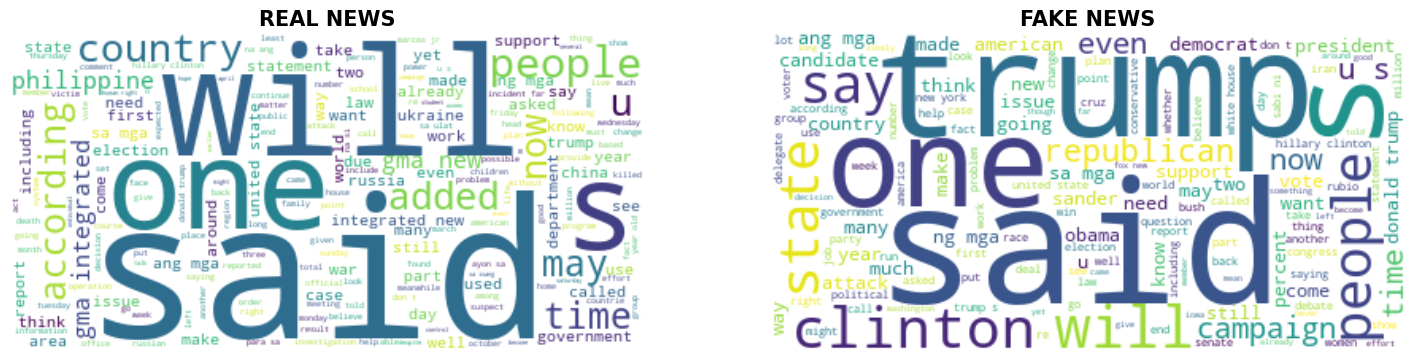

In [48]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
# Plotting the initial word cloud for REAL NEWS
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_rn, interpolation='bilinear')
plt.axis('off')
plt.title("REAL NEWS", fontsize=15, weight='bold')

# Plotting the initial word cloud for FAKE NEWS
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.axis('off')
plt.title("FAKE NEWS", fontsize=15, weight='bold')

#### Figure 1. Initial Word Cloud for each label

As observed in the word clouds displayed above, they contain numerous extraneous elements like fillers and blank spaces (' '). To enhance data cleanliness, we will eliminate these fillers and blank spaces. Additionally, we will exclude stop words from the data to ensure that only essential and relevant words are shown.

### Excluding Stop Words, Fillers, and Blank Spaces

We will first retrieve the stop words from SpaCy and merge them with the fillers and blank spaces identified in the initial word clouds. Subsequently, we will instruct the [`WorldClouds()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html)  to exclude these specific texts and characters when creating new word clouds for each label.

In [49]:
sp = spacy.load('en_core_web_sm')

# Accesing the stopwords package from SpaCy
all_stopwords = sp.Defaults.stop_words
# List of the fillers and blank space 
new_stopwords=["filler", " ", "S", "t", "s", "u", " "]
# Combining trhe stopwords, fillers, and blank space
comb_stopwords=list(new_stopwords)+list(all_stopwords)

# Generating the word clouds
wordcloud_rn = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_rn)
wordcloud_fn = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_fn)

We will now be generating new word clouds that exclude any texts and characters that we removed in the previous step.

Text(0.5, 1.0, 'FAKE NEWS')

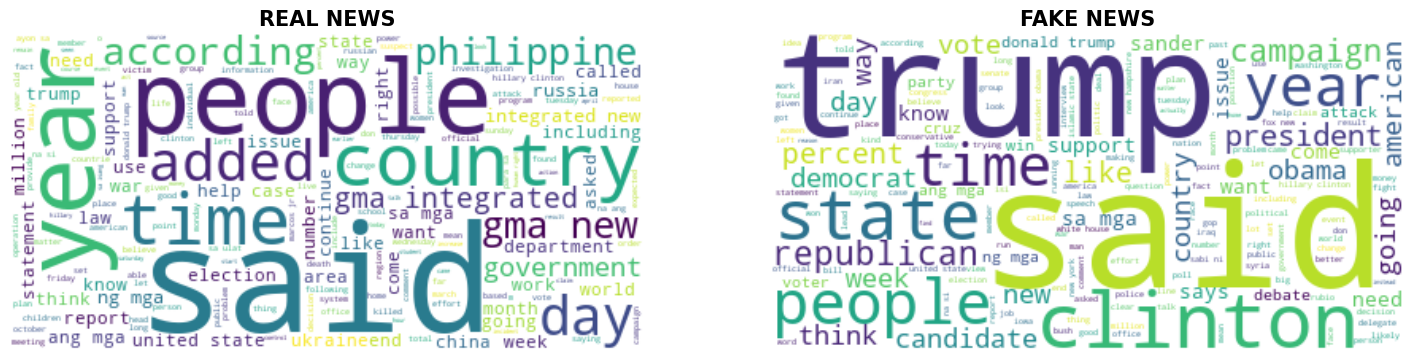

In [50]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
# Plotting the initial word cloud for Real News
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_rn, interpolation='bilinear')
plt.axis('off')
plt.title("REAL NEWS", fontsize=15, weight='bold')

# Plotting the initial word cloud for Fake News
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.axis('off')
plt.title("FAKE NEWS", fontsize=15, weight='bold')

#### Figure 2. Updated Word Cloud for each label (Excluded Stopwords, Fillers, and Blank Spaces

In the depicted figure, the wordclouds appear more refined. For the real label, the most prominent words are 'said,' 'year,' 'people,' 'country,' 'added,' and 'time,' indicating their high occurrence in this category. On the other hand, for the fake label, words such as 'trump,' 'clinton,' 'state,' 'said,' and 'people' are found to be the most common occurrences.

### Excluding Verbs and Contractions

The next round of word clouds will be created, but this time, we will exclude verbs and contractions from the analysis. To gain more valuable insights from the data, we will treat verbs as stopwords, meaning they will not be included in the word clouds. However, existing libraries do not classify verbs as stopwords by default, so we will manually add them to the current list of stopwords. As a result, the focus will be on nouns, providing a clearer picture for the upcoming word clouds.

In [51]:
all_stopwords = sp.Defaults.stop_words
new_stopwords_nv=["filler", " ", "S", "t", "s", "u", " ", "added", "believe", "use", "saying", "said", "tell", "help", "run", "work", "says", "come", "told", "like", "know", "asked", "vote", "going", "make", "support", "debate" "sabi", "help", "think", "provide", "▯"]
comb_stopwords=list(new_stopwords_nv)+list(all_stopwords)

# Generating the word clouds
wordcloud_rn_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_rn)
wordcloud_fn_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_fn)

Next, we are going to generate new visualizations using the updated word clouds.

Text(0.5, 1.0, 'FAKE NEWS (mostly noun)')

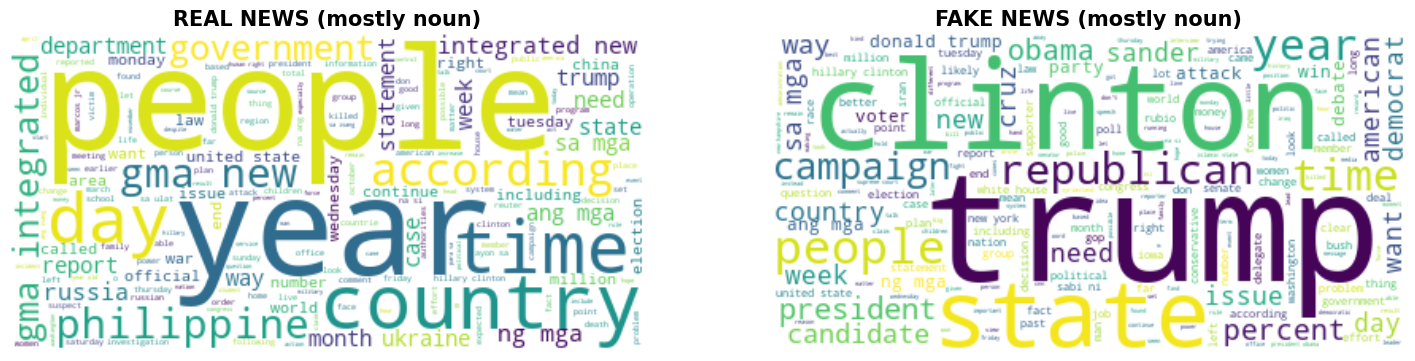

In [52]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_rn_nv, interpolation='bilinear')
plt.axis('off')
plt.title("REAL NEWS (mostly noun)", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_fn_nv, interpolation='bilinear')
plt.axis('off')
plt.title("FAKE NEWS (mostly noun)", fontsize=15, weight='bold')

#### Figure 3. Latest Word Cloud for each label (Excluded Stopwords, Fillers, Blank Spaces, Verbs, and Contractions)

From the word clouds shown above, it is evident that the real label prominently displays words like 'people', 'country', 'year', 'time', and 'according' in a visually larger size. Conversely, the fake label exhibits larger words such as 'trump', 'clinton', 'state', 'people', and 'year'.

### Word Cloud using TF-IDF

To start, we will be making a copy of the Real News data rn and Fake News fn.

In [53]:
rn_tf = rn[['Content']].copy(deep=True)
fn_tf = fn[['Content']].copy(deep=True)

#### Lemmatization

We will perform lemmatization using [`WordNetLemmatizer()`](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnetlemmatizer) first before converting the dataset into TF-IDF vectors o ensure that the words are in their base form and reduced to the most essential form. To achieve this, we have developed the clean_text function, which is responsible for cleaning the text and generating a text free from unnecessary noise and unwanted words.

In [54]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

rn_tf["text_clean"] = rn_tf["Content"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...'@#_]", " ", s).split()))
fn_tf["text_clean"] = fn_tf["Content"].apply(lambda s: ' '.join(re.sub(r'\d+', '', s).split()))

def clean_text(input_txt):
    words_rn_tf = input_txt.lower().split()
    words_rn_tf = [word for word in words_rn_tf if word not in stop_words and new_stopwords_nv] 
    words_rn_tf = [lemmatizer.lemmatize(word, pos='v') for word in words_rn_tf]
    words_rn_tf = [word for word in words_rn_tf if len(word) > 2]
    noise_free_text = " ".join(words_rn_tf) 
    return noise_free_text

rn_tf["text_clean"] = rn_tf["text_clean"].apply(lambda s: clean_text(s))


fn_tf["text_clean"] = fn_tf["Content"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...'@#_]", " ", s).split()))
fn_tf["text_clean"] = fn_tf["Content"].apply(lambda s: ' '.join(re.sub(r'\d+', '', s).split()))

def clean_text_s(input_txt):
    words_fn_tf = input_txt.lower().split()
    words_fn_tf = [word for word in words_fn_tf if word not in stop_words and new_stopwords_nv] 
    words_fn_tf = [lemmatizer.lemmatize(word, pos='v') for word in words_fn_tf]
    words_fn_tf = [word for word in words_fn_tf if len(word) > 2]
    noise_free_text = " ".join(words_fn_tf) 
    return noise_free_text

fn_tf["text_clean"] = fn_tf["text_clean"].apply(lambda s: clean_text(s))

### Vectorization

Once the texts have undergone lemmatization, we proceed to apply the TF-IDF vectorizer on both dataframes. To ensure a concise representation, we set the max_features value to 50, which allows us to select only the top 50 words with the highest TF-IDF scores. This approach helps us focus on the most significant words, making the analysis more efficient and meaningful.

In [55]:
tfidf_stop_words = list(text.ENGLISH_STOP_WORDS.union(["ll", "gt", "lt", "filler", "don", "ve"]))

# Initialization of TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=tfidf_stop_words, max_features=50)

# Implementing vectorization per label lemmatized data
df_vec_rn = tfidf_vectorizer.fit_transform(rn_tf["text_clean"])
df_vec_fn = tfidf_vectorizer.fit_transform(fn_tf["text_clean"])

After this step, the resulting matrix will be transformed into a dataframe.

In [56]:
df_rn_tf = pd.DataFrame(df_vec_rn.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_fn_tf = pd.DataFrame(df_vec_fn.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#### Result data for Real  News label

We can observe the frequency score of each word (from the top 50 words) for every data entry in the real news label.

In [57]:
df_rn_tf

,american,ang,bush,campaign,clinton,come,country,cruz,debate,democratic,...,time,trump,use,vote,voters,want,white,work,year,years
0,0.173353,0.000000,0.000000,0.792684,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.912173,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.904324,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.766171,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.468949,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18631,0.000000,0.000000,0.184636,0.481508,0.0,0.000000,0.583389,0.0,0.074694,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.256480
18632,0.000000,0.212477,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.208983,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
18633,0.000000,0.142140,0.000000,0.126227,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.537887
18634,0.533051,0.091492,0.083080,0.081249,0.0,0.146185,0.098440,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.101227,0.0,0.0,0.0,0.388496,0.0,0.000000


#### Result data for Fake News label

The same can be observed in the fake news label

In [58]:
df_fn_tf

,american,ang,bush,campaign,clinton,come,country,cruz,debate,democratic,...,time,trump,use,vote,voters,want,white,work,year,years
0,0.000000,0.652181,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.804995,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.945301,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.073320,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.691383,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.934371,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354766
4494,0.146137,0.000000,0.000000,0.000000,0.000000,0.000000,0.140750,0.0,0.000000,0.000000,...,0.000000,0.437943,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4495,0.000000,0.000000,0.000000,0.036476,0.815325,0.033581,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.039013,0.000,0.000000,0.000000,0.000000,0.265046,0.075703,0.114033
4496,0.050633,0.000000,0.064988,0.000000,0.000000,0.124284,0.097532,0.0,0.000000,0.052241,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.155972,0.093423,0.140090,0.187573


Next, we will examine the top 50 words that have been chosen and arrange them based on the overall frequency scores in each data point for each category. We will employ the [`sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html?highlight=sum#pandas.DataFrame.sum) function to calculate the total occurrence count of each word across all data points within a specific label. Once this is done, we will use the [`sort_values()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html?highlight=sort_values#pandas.DataFrame.sort_values) method to arrange the words in ascending order, based on their total occurrence values.

In [59]:
tf_idf_counter_rn = df_rn_tf.T.sum(axis=1).sort_values(ascending=False)
tf_idf_counter_fn = df_fn_tf.T.sum(axis=1).sort_values(ascending=False)

#### Ranking words for the real news label

In [60]:
tf_idf_counter_rn

tell            4378.469819
campaign        3806.423478
percent         1723.544565
republican      1202.855044
republicans     1190.927968
hillary         1176.267635
say             1174.568509
run             1107.628568
think           1061.388242
house           1051.032199
said            1043.933149
country         1041.796644
bush            1006.500429
presidential     972.583582
trump            963.891403
clinton          955.608234
work             933.598406
party            919.356674
ang              907.897297
democratic       865.123578
political        858.108828
right            849.039968
years            827.770516
vote             800.279942
american         799.091336
sanders          796.507232
know             793.730911
people           784.728439
gop              768.084502
mga              760.745945
make             759.559974
government       715.963149
include          701.977275
support          700.086870
national         692.275969
time             683

Here, the top 5 most frequent words in the real label are as follows:

- "tell" with a frequency of 4378.469819
- "campaign" with a frequency of 3806.423478
- "percent" with a frequency of 1723.544565
- "republican" with a frequency of 1202.855044
- "republicans" with a frequency of 1190.927968

#### Ranking words for the fake news label

In [61]:
tf_idf_counter_fn

ang             1263.425062
say              636.665587
mga              624.349292
trump            573.280842
clinton          388.996185
state            385.941287
said             317.167873
obama            315.066461
president        305.616106
people           297.143431
make             263.125893
new              261.391076
campaign         233.564480
time             229.036291
party            218.190087
republican       213.936725
house            206.222684
tell             205.481087
news             198.455968
government       196.414171
year             193.282560
like             191.184148
percent          188.904009
vote             188.673772
come             183.054367
right            173.472162
think            171.110982
know             168.472775
sanders          168.236072
political        167.701049
presidential     165.227847
republicans      163.985650
work             163.626368
use              163.511256
cruz             162.789764
years            158

On the other hand, the most common words in the fake label are:

- "ang" with a frequency of 1263.425062
- "say" with a frequency of 636.665587
- "mga" with a frequency of 624.349292
- "trump" with a frequency of 573.280842
- "clinton" with a frequency of 388.996185

To create the word cloud using TF-IDF, the [`generate_from_frequencies()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) function is utilized instead of the [`generate()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) function. 

In [62]:
wordcloud_tf_rn = WordCloud(width = 3000, height = 2000, random_state=1,background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(tf_idf_counter_rn)

wordcloud_tf_fn = WordCloud(width = 3000, height = 2000, random_state=1,background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(tf_idf_counter_fn)

Having created a word cloud for each label, we can now visualize and compare the differences in word frequency scores between them.

Text(0.5, 1.0, 'FAKE NEWS')

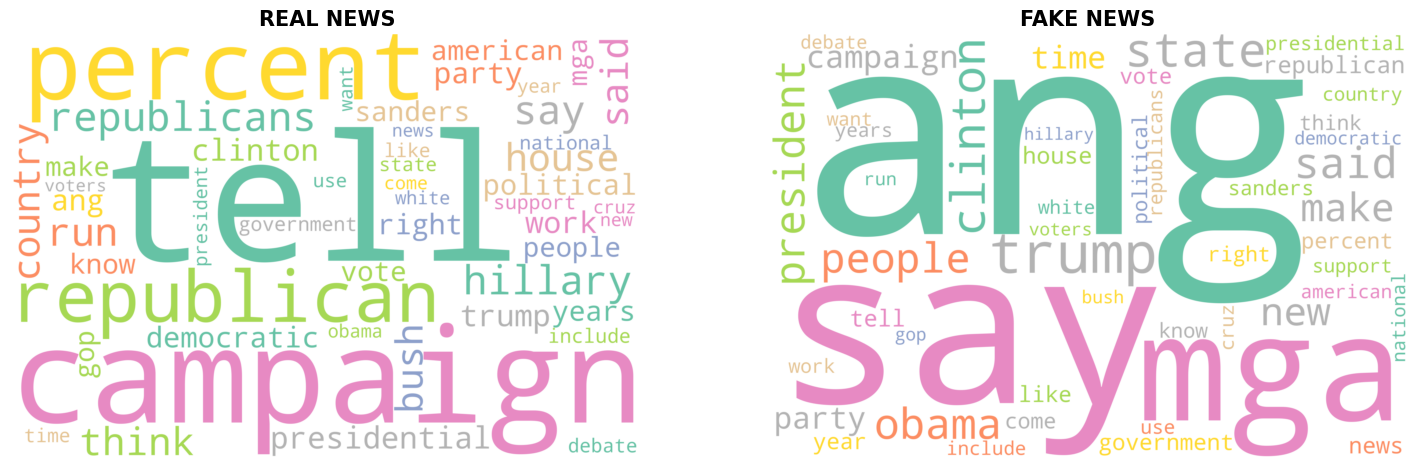

In [63]:
fig = plt.figure(figsize=(18, 13))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_tf_rn, interpolation='bilinear')
plt.axis("off")
plt.title("REAL NEWS", fontsize=15, weight='bold')

fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_tf_fn, interpolation='bilinear')
plt.axis("off")
plt.title("FAKE NEWS", fontsize=15, weight='bold')

### Figure 4. Word Cloud after TF-IDF

As shown in figure above, it is clear that the top 5 words for the real label are "tell," "campaign," "percent," "republican," and "republicans." Conversely, the top 5 words for the fake label are "ang," "say," "mga," "trump," and "said." 

Nevertheless, relying solely on the word cloud might be misleading as some words appear almost as large as the actual top 5 words in each label. To get a more accurate understanding of the top words in each label, it is advisable to examine the ranking of words based on their frequency scores. This way, we can identify the most significant words in each class more effectively.

## 2. What is the range of character counts of the news for each of the labels?

### REAL NEWS

Firstly, we'll create a duplicate of the dataframe that exclusively includes data from the real label. This duplicate will be referred to as "rn_2."

In [64]:
rn_2 = rn[['Content']].copy(deep=True)
rn_2

,Content
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,"Kasama sa programa ang pananalangin, bulaklak ..."
4,Linisin ang Friendship Department dahil dadala...
...,...
23129,The winner of the special election in Cavite t...
23130,The remains of four people inside the Cessna p...
23131,A Kabataan Party-list representative visited t...
23132,The Philippine Coast Guard is expected to have...


In the real label, the length of each statement is determined by counting the number of words using the [`count()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.count.html?highlight=count#pandas.Series.str.count) function, and then adding 1 to account for the offset, which gives us the "length" variable. Additionally, the length of each statement is measured by the number of characters using the [`len()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html?highlight=len#pandas.Series.str.len) function to count the characters in each text data, resulting in the "LoR" variable.

Next, the "length" and "LoR" values are placed in separate columns within the rn_2 dataframe for further analysis and comparison.

In [65]:
rn_2['length'] = rn_2['Content'].str.count(' ') + 1
rn_2['LoR'] = rn_2['Content'].str.len()
rn_2

,Content,length,LoR
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",257,1585
1,Kilala rin ang singer sa pagkumpas ng kanyang ...,153,920
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",52,342
3,"Kasama sa programa ang pananalangin, bulaklak ...",65,410
4,Linisin ang Friendship Department dahil dadala...,26,157
...,...,...,...
23129,The winner of the special election in Cavite t...,683,4130
23130,The remains of four people inside the Cessna p...,262,1481
23131,A Kabataan Party-list representative visited t...,288,1817
23132,The Philippine Coast Guard is expected to have...,333,2025


Afterward, the average length (number of words in a text data) and the average LoR (number of characters in a text data) are computed by using the [`mean()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html?highlight=mean#pandas.DataFrame.mean) function.

In [66]:
rn_2["length"].mean()

400.8288259283108

In [67]:
rn_2["LoR"].mean()

2444.39734921657

According to the findings above, the average statement length in the real label is approximately 400 words. Additionally, the average number of characters is approximately 2444 characters per statement.

### FAKE NEWS

Now, we will be doing the same process as what we did in the real label with fake label. The only difference is that we will be making a copy of the dataframe which only contain data under the fake label and will be renamed as fn_2

In [68]:
fn_2 = fn[['Content']].copy(deep=True)
fn_2

,Content
1496,Isiniwalat ng isang tribal leader ang kabalbal...
1497,Kilala ang Univeristy of the Philippines (UP) ...
1498,Ayon kay Tourism Secretary Bernadette Romulo-P...
1499,Sa opisyal na pagpapakilala ng mga taga-oposis...
1500,Hindi pinalampas ni dating Presidential Commun...
...,...
9055,Most conservatives who oppose marriage equalit...
9058,The freshman senator from Georgia quoted scrip...
9060,The State Department told the Republican Natio...
9063,"ADDIS ABABA, Ethiopia —President Obama convene..."


Similar to what we did in the rn_2 dataframe, the "length" and "LoR" values are placed in separate columns within the fn_2 dataframe for further analysis and comparison.

In [69]:
fn_2['length'] = fn_2['Content'].str.count(' ') + 1
fn_2['LoR'] = fn_2['Content'].str.len()
fn_2

,Content,length,LoR
1496,Isiniwalat ng isang tribal leader ang kabalbal...,423,2546
1497,Kilala ang Univeristy of the Philippines (UP) ...,172,1059
1498,Ayon kay Tourism Secretary Bernadette Romulo-P...,204,1251
1499,Sa opisyal na pagpapakilala ng mga taga-oposis...,112,683
1500,Hindi pinalampas ni dating Presidential Commun...,157,988
...,...,...,...
9055,Most conservatives who oppose marriage equalit...,293,1822
9058,The freshman senator from Georgia quoted scrip...,376,2212
9060,The State Department told the Republican Natio...,677,4076
9063,"ADDIS ABABA, Ethiopia —President Obama convene...",1145,6991


The average length (number of words in a text data) and the average LoR (number of characters in a text data) are also computed by using the [`mean()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html?highlight=mean#pandas.DataFrame.mean) function.

In [70]:
fn_2["length"].mean()

703.9791018230325

In [71]:
fn_2["LoR"].mean()

4199.221654068475

From the data shown above, we observe that the average length of statements in the fake label is approximately 703 words. Additionally, the average length number of characters is found to be around 4199 characters.

Comparing the results of the two label, it is evident that the fake label has a greater average length of statements as compared to real label. The same can be said when it comes to the number of characters of each label. This difference suggests that fake news content may involve more elaborate narratives, potentially using sensationalized language to capture attention and present a sense of credibility. Longer statements could also aim to overwhelm readers with excessive information, making fact-checking more challenging. 

## 3. What are the sentiment score of the statements per labels?

Again, like how it was done before in the two previous question, we will be creating a copy of the real news and fake news label dataframes for this question.

In [72]:
rn_SA = rn.copy(deep=True)
fn_SA = fn.copy(deep=True)

## Real News

Firstly, the text column in the dataframes will be converted to lowercase using the [`lower()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html?highlight=lower#pandas.Series.str.lower) function. Afterward, tokenization will be applied using the [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.regexp.html) to facilitate sentiment analysis at a token level.

In [73]:
# Lowercase the texts
rn_SA['Content'] = rn_SA['Content'].astype(str).str.lower() #real news
fn_SA['Content'] = fn_SA['Content'].astype(str).str.lower() #fake news

# Initialize tokenizer
regexp = RegexpTokenizer('\w+')

# Apply tokenizer
rn_SA['text_token']= rn_SA['Content'].apply(regexp.tokenize) #real news
fn_SA['text_token']= fn_SA['Content'].apply(regexp.tokenize) #fake news

Following the tokenization process, a new column will be appended to the dataframes, containing the tokenized statements combined into a single text string. Before tokenization, the [`stopwords`](https://www.nltk.org/howto/corpus.html?highlight=stopwords) package was employed to identify and remove stopwords and other irrelevant words, thereby enhancing processing efficiency.

In [74]:
# Initialize stopwords
stopwords = nltk.corpus.stopwords.words("english")

my_stopwords = ['https']
stopwords.extend(my_stopwords)

stopwords is then removed from the tokenized text data and converts the processed tokens back into strings for real news dataset.

In [75]:
#Real News
rn_SA['text_token'] = rn_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
rn_SA['text_string'] = rn_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
rn_SA[['Content', 'text_token', 'text_string']]

,Content,text_token,text_string
0,"ayon sa thewrap.com, naghain ng kaso si krupa,...","[ayon, sa, thewrap, com, naghain, ng, kaso, si...",ayon thewrap com naghain kaso krupa noong huwe...
1,kilala rin ang singer sa pagkumpas ng kanyang ...,"[kilala, rin, ang, singer, sa, pagkumpas, ng, ...",kilala rin ang singer pagkumpas kanyang kamay ...
2,"blantyre, malawi (ap) -- bumiyahe patungong ma...","[blantyre, malawi, ap, bumiyahe, patungong, ma...",blantyre malawi bumiyahe patungong malawi mado...
3,"kasama sa programa ang pananalangin, bulaklak ...","[kasama, sa, programa, ang, pananalangin, bula...",kasama programa ang pananalangin bulaklak pags...
4,linisin ang friendship department dahil dadala...,"[linisin, ang, friendship, department, dahil, ...",linisin ang friendship department dahil dadala...
...,...,...,...
23129,the winner of the special election in cavite t...,"[winner, special, election, cavite, fill, cong...",winner special election cavite fill congressio...
23130,the remains of four people inside the cessna p...,"[remains, four, people, inside, cessna, plane,...",remains four people inside cessna plane crashe...
23131,a kabataan party-list representative visited t...,"[kabataan, party, list, representative, visite...",kabataan party list representative visited are...
23132,the philippine coast guard is expected to have...,"[philippine, coast, guard, expected, additiona...",philippine coast guard expected additional 000...


The same process is applied to the DataFrame fn_SA to process the text data for fake news.

In [76]:
#Fake News
fn_SA['text_token'] = fn_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
fn_SA['text_string'] = fn_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
fn_SA[['Content', 'text_token', 'text_string']]

,Content,text_token,text_string
1496,isiniwalat ng isang tribal leader ang kabalbal...,"[isiniwalat, ng, isang, tribal, leader, ang, k...",isiniwalat isang tribal leader ang kabalbalang...
1497,kilala ang univeristy of the philippines (up) ...,"[kilala, ang, univeristy, philippines, dahil, ...",kilala ang univeristy philippines dahil isa it...
1498,ayon kay tourism secretary bernadette romulo-p...,"[ayon, kay, tourism, secretary, bernadette, ro...",ayon kay tourism secretary bernadette romulo p...
1499,sa opisyal na pagpapakilala ng mga taga-oposis...,"[sa, opisyal, na, pagpapakilala, ng, mga, taga...",opisyal pagpapakilala mga taga oposisyon kanil...
1500,hindi pinalampas ni dating presidential commun...,"[hindi, pinalampas, ni, dating, presidential, ...",hindi pinalampas dating presidential communica...
...,...,...,...
9055,most conservatives who oppose marriage equalit...,"[conservatives, oppose, marriage, equality, ci...",conservatives oppose marriage equality cite bi...
9058,the freshman senator from georgia quoted scrip...,"[freshman, senator, georgia, quoted, scripture...",freshman senator georgia quoted scripture righ...
9060,the state department told the republican natio...,"[state, department, told, republican, national...",state department told republican national comm...
9063,"addis ababa, ethiopia —president obama convene...","[addis, ababa, ethiopia, president, obama, con...",addis ababa ethiopia president obama convened ...


The text, which has already been tokenized, will now undergo re-tokenization using the nltk tokenize package, this time based on space and punctuation. Then, [`FreqDist`](https://www.nltk.org/api/nltk.probability.FreqDist.html?highlight=freqdist) is utilized to calculate the frequency of each word in a statement. 

In [77]:
#Real News
all_words = ' '.join([word for word in rn_SA['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

fdist = FreqDist(tokenized_words)

rn_SA['text_string_fdist'] = rn_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
rn_SA[['Content', 'text_token', 'text_string', 'text_string_fdist']].tail()

,Content,text_token,text_string,text_string_fdist
23129,the winner of the special election in cavite t...,"[winner, special, election, cavite, fill, cong...",winner special election cavite fill congressio...,winner special election cavite fill congressio...
23130,the remains of four people inside the cessna p...,"[remains, four, people, inside, cessna, plane,...",remains four people inside cessna plane crashe...,remains four people inside cessna plane crashe...
23131,a kabataan party-list representative visited t...,"[kabataan, party, list, representative, visite...",kabataan party list representative visited are...,kabataan party list representative visited are...
23132,the philippine coast guard is expected to have...,"[philippine, coast, guard, expected, additiona...",philippine coast guard expected additional 000...,philippine coast guard expected additional 000...
23133,national bureau of investigation-national capi...,"[national, bureau, investigation, national, ca...",national bureau investigation national capital...,national bureau investigation national capital...


In [78]:
#Fake News
all_words = ' '.join([word for word in fn_SA['text_string']])

fn_SA['text_string_fdist'] = fn_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
fn_SA[['Content', 'text_token', 'text_string', 'text_string_fdist']].tail()

,Content,text_token,text_string,text_string_fdist
9055,most conservatives who oppose marriage equalit...,"[conservatives, oppose, marriage, equality, ci...",conservatives oppose marriage equality cite bi...,conservatives oppose marriage equality cite bi...
9058,the freshman senator from georgia quoted scrip...,"[freshman, senator, georgia, quoted, scripture...",freshman senator georgia quoted scripture righ...,freshman senator georgia quoted scripture righ...
9060,the state department told the republican natio...,"[state, department, told, republican, national...",state department told republican national comm...,state department told republican national comm...
9063,"addis ababa, ethiopia —president obama convene...","[addis, ababa, ethiopia, president, obama, con...",addis ababa ethiopia president obama convened ...,addis ababa ethiopia president obama convened ...
9064,jeb bush is suddenly attacking trump. here's w...,"[jeb, bush, suddenly, attacking, trump, matter...",jeb bush suddenly attacking trump matters jeb ...,jeb bush suddenly attacking trump matters jeb ...


Following that, lemmatization is implemented using [`WordNetLemmatizer()`](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnetlemmatizer) to group words with the same base form together, treating them as one for analysis.

In [79]:
#Real News
wordnet_lem = WordNetLemmatizer()

rn_SA['text_string_lem'] = rn_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

# check if the columns are equal
rn_SA['is_equal']= (rn_SA['text_string_fdist']== rn_SA['text_string_lem'])
# show level count
rn_SA.is_equal.value_counts()

True    18636
Name: is_equal, dtype: int64

In [80]:
#Fake News

fn_SA['text_string_lem'] = fn_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

# check if the columns are equal
fn_SA['is_equal']= (fn_SA['text_string_fdist'] == fn_SA['text_string_lem'])
# show level count
fn_SA.is_equal.value_counts()

True    4498
Name: is_equal, dtype: int64

In this analysis, the lemmatized text string undergoes sentiment analysis, which involves generating negative, neutral, positive, and compound scores for each statement. The compound score represents the overall sentiment of the statement. [`NLTK Sentiment Analysis`](https://www.nltk.org/api/nltk.sentiment.html?highlight=nltk+sentiment+analysis) will be employed to perform sentiment analysis in this section.

### NLTK Sentiment Analysis

### Real News

To perform sentiment analysis on the lemmatized text in the dataframe, the [`SentimentIntensityAnalyzer`](https://www.nltk.org/api/nltk.sentiment.SentimentIntensityAnalyzer.html?highlight=sentimentintensityanalyzer#nltk.sentiment.SentimentIntensityAnalyzer) from the NLTK library will be used wherein it would calculate the polarity scores for each statement and assigns them to a new column called "polarity" in the same dataframe. After that, the data structure will be modified by dropping the original "polarity" column and concatenating the scores from the "polarity" column into separate columns: "negative," "neutral," "positive," and "compound." 

In [81]:
analyzer = SentimentIntensityAnalyzer()

rn_SA['polarity'] = rn_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
rn_SA = pd.concat(
     [rn_SA.drop(['polarity'], axis=1), 
     rn_SA['polarity'].apply(pd.Series)], axis=1)

Each statement's sentiment is categorized based on its compound score.

In [82]:
def condition(x):
    if x>0:
        return "positive"
    elif x==0:
        return "neutral"
    else:
        return 'negative'

rn_SA['sentiment'] = rn_SA['compound'].apply(condition)

rn_SA.tail()

,label,Content,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
23129,0,the winner of the special election in cavite t...,"[winner, special, election, cavite, fill, cong...",winner special election cavite fill congressio...,winner special election cavite fill congressio...,winner special election cavite fill congressio...,True,0.024,0.863,0.112,0.9897,positive
23130,0,the remains of four people inside the cessna p...,"[remains, four, people, inside, cessna, plane,...",remains four people inside cessna plane crashe...,remains four people inside cessna plane crashe...,remains four people inside cessna plane crashe...,True,0.109,0.844,0.047,-0.8481,negative
23131,0,a kabataan party-list representative visited t...,"[kabataan, party, list, representative, visite...",kabataan party list representative visited are...,kabataan party list representative visited are...,kabataan party list representative visited are...,True,0.053,0.838,0.109,0.8225,positive
23132,0,the philippine coast guard is expected to have...,"[philippine, coast, guard, expected, additiona...",philippine coast guard expected additional 000...,philippine coast guard expected additional 000...,philippine coast guard expected additional 000...,True,0.033,0.810,0.158,0.9723,positive
23133,0,national bureau of investigation-national capi...,"[national, bureau, investigation, national, ca...",national bureau investigation national capital...,national bureau investigation national capital...,national bureau investigation national capital...,True,0.090,0.831,0.079,-0.2263,negative


We will be utilizing the [`value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html?highlight=value_counts#pandas.DataFrame.value_counts) function to examine the total number of positive, negative, and neutral statements in the real news label. The results indicate that a majority of the statements in this label are categorized as having a positive sentiment, however, there is still a significant number of statements with negative sentiments.

In [83]:
rn_SA['sentiment'].value_counts()

positive    8920
negative    8540
neutral     1176
Name: sentiment, dtype: int64

To visualize this distribution, a [`bar plot`](https://seaborn.pydata.org/generated/seaborn.barplot.html?highlight=vertical+bar+plots) is generated to represent the count of each sentiment category.

Text(0.5, 1.0, 'Real News label Sentiment Text Values by Counts')

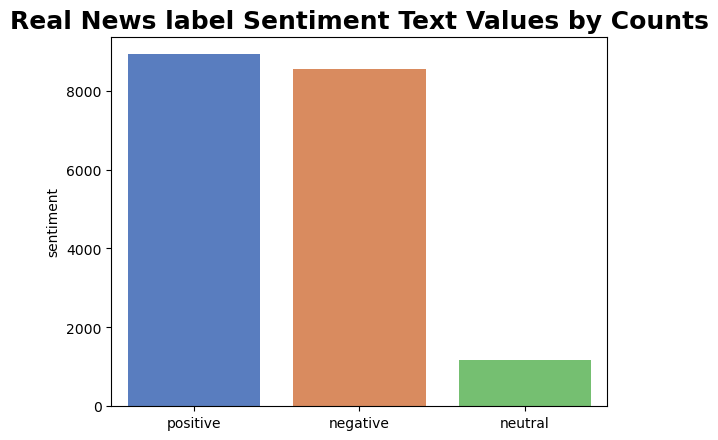

In [84]:
sns.set_palette('muted')
ax = sns.barplot(x=rn_SA['sentiment'].value_counts().index, y=rn_SA['sentiment'].value_counts())
ax.set_title('Real News label Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

#### Figure 5. Real News label Sentiment Text Values by Counts

From this figure, positive texts (8920) has the highest quantity for the real news label. Another finding from this figure is that there are more negative texts (8540) than neutral texts (1176) in this label. This suggests that the content in the real news dataset tends to convey positive or favorable information. On the other hand, the presence of a significant number of negative texts indicates that there are also instances of negative or unfavorable information being reported in the real news dataset.

## Fake News

The same process as the rn_SA dataframe will be applied to the fn_SA dataframe to perform sentiment analysis on the lemmatized text in the dataframe.

In [85]:
fn_SA['polarity'] = fn_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
fn_SA = pd.concat(
     [fn_SA.drop(['polarity'], axis=1), 
     fn_SA['polarity'].apply(pd.Series)], axis=1)

Each statement's sentiment is categorized based on its compound score.

In [86]:
fn_SA['sentiment'] = fn_SA['compound'].apply(condition)

fn_SA.tail()

,label,Content,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
9055,1,most conservatives who oppose marriage equalit...,"[conservatives, oppose, marriage, equality, ci...",conservatives oppose marriage equality cite bi...,conservatives oppose marriage equality cite bi...,conservatives oppose marriage equality cite bi...,True,0.055,0.770,0.175,0.9559,positive
9058,1,the freshman senator from georgia quoted scrip...,"[freshman, senator, georgia, quoted, scripture...",freshman senator georgia quoted scripture righ...,freshman senator georgia quoted scripture righ...,freshman senator georgia quoted scripture righ...,True,0.094,0.692,0.214,0.9747,positive
9060,1,the state department told the republican natio...,"[state, department, told, republican, national...",state department told republican national comm...,state department told republican national comm...,state department told republican national comm...,True,0.046,0.895,0.059,0.6369,positive
9063,1,"addis ababa, ethiopia —president obama convene...","[addis, ababa, ethiopia, president, obama, con...",addis ababa ethiopia president obama convened ...,addis ababa ethiopia president obama convened ...,addis ababa ethiopia president obama convened ...,True,0.093,0.747,0.160,0.9920,positive
9064,1,jeb bush is suddenly attacking trump. here's w...,"[jeb, bush, suddenly, attacking, trump, matter...",jeb bush suddenly attacking trump matters jeb ...,jeb bush suddenly attacking trump matters jeb ...,jeb bush suddenly attacking trump matters jeb ...,True,0.119,0.756,0.125,0.2351,positive


For the Fake News, it shows that the majority of the statements are categorized as also having positive sentiment, and also with negative sentiments being the second highest and neutral sentiment being the lowest.

In [87]:
fn_SA['sentiment'].value_counts()

positive    2587
negative    1734
neutral      177
Name: sentiment, dtype: int64

To visualize the distribution for the Fake News label, a [`bar plot`](https://seaborn.pydata.org/generated/seaborn.barplot.html?highlight=vertical+bar+plots) is generated as well.

Text(0.5, 1.0, 'Fake News label Sentiment Text Values by Counts')

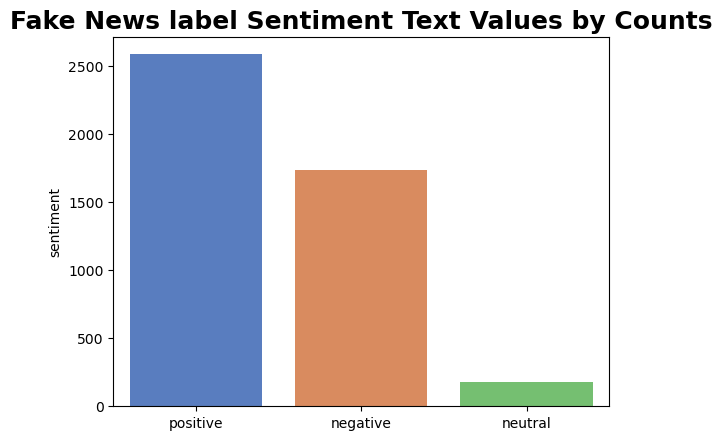

In [88]:
sns.set_palette('muted')
ax = sns.barplot(x= fn_SA['sentiment'].value_counts().index, y=fn_SA['sentiment'].value_counts())
ax.set_title('Fake News label Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

#### Figure 6. Real News label Sentiment Text Values by Counts

The figure illustrates the distribution of sentiments within the fake news label. It indicates that the majority of statements in the fake news dataset are classified as positive, with a count of 2587 statements. The second-highest sentiment category is negative, with 1734 statements. The smallest category is neutral, comprising only 177 statements. This distribution provides valuable insights into the overall sentiment patterns within the fake news dataset, highlighting the prevalence of positive sentiments and the relatively lower occurrence of neutral sentiments.

The sentiment distribution within the fake news dataset reveals three key implications:
   - a higher count of positive statements suggests that a significant portion of the fake news articles convey a positive or favorable tone, possibly aiming to promote specific narratives and influence readers' perceptions. 
   
   - the considerable number of negative statements indicates that fake news articles also employ negative language to invoke emotional responses and create a sense of urgency. This polarization in sentiment can contribute to the spread of misinformation, as emotionally charged content tends to attract more attention and engagement.
   
  - the relatively lower number of neutral statements further reinforces the notion that fake news often employs polarizing and emotive language to create impact and engagement.

## 4. Among the articles written in Filipino and English, which language predominantly contains the most real or fake news labels?

To answer this question, we would be needing to load the csv files, using [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html?highlight=read_csv#pandas.read_csv) for English news and Filipino news articles.

In [89]:
df_english_news = pd.read_csv('english_news.csv')
df_english_news.head()

,label,Content,language
0,0,"""People should fact-check. People shouldn't ha...",English
1,0,"""We will implement the integration on February...",English
2,0,"""No one knows what exactly was said to Adam, b...",English
3,0,"""In the consideration of safety, management an...",English
4,0,"""A month after the incident and here we are, e...",English


In [90]:
df_filipino_news = pd.read_csv('filipino_news.csv')
df_filipino_news.head()

,label,Content,language
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",Filipino
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,Filipino
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",Filipino
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",Filipino
4,0,Linisin ang Friendship Department dahil dadala...,Filipino


To count the number of real and fake news labels, we filter the dataframes based on the 'label' column. We then calculate the counts of real and fake news labels using the shape attribute of the filtered dataframes. The shape attribute returns a tuple (rows, columns), so shape[0] gives us the number of rows or the count of real/fake news.

In [91]:
english_real_count = df_english_news[df_english_news['label'] == 0].shape[0]
english_fake_count = df_english_news[df_english_news['label'] == 1].shape[0]

filipino_real_count = df_filipino_news[df_filipino_news['label'] == 0].shape[0]
filipino_fake_count = df_filipino_news[df_filipino_news['label'] == 1].shape[0]

We then compare the counts for English and Filipino news to determine which language has the most real and fake news labels. We use if-else statements to assign the most frequent language to variables most_real_language and most_fake_language.

In [92]:
# Compare the counts to determine which language has the most real and fake news labels
if english_real_count > filipino_real_count:
    most_real_language = 'English'
    most_real_count = english_real_count
else:
    most_real_language = 'Filipino'
    most_real_count = filipino_real_count

if english_fake_count > filipino_fake_count:
    most_fake_language = 'English'
    most_fake_count = english_fake_count
else:
    most_fake_language = 'Filipino'
    most_fake_count = filipino_fake_count

# Display the results
print(f"Language with the most Real News: {most_real_language}, Count: {most_real_count}")
print(f"Language with the most Fake News: {most_fake_language}, Count: {most_fake_count}")

Language with the most Real News: English, Count: 14419
Language with the most Fake News: English, Count: 3107


We also create a [`bar plot`](https://seaborn.pydata.org/generated/seaborn.objects.Stack.html?highlight=bar+stack+plot) to visualize this result.

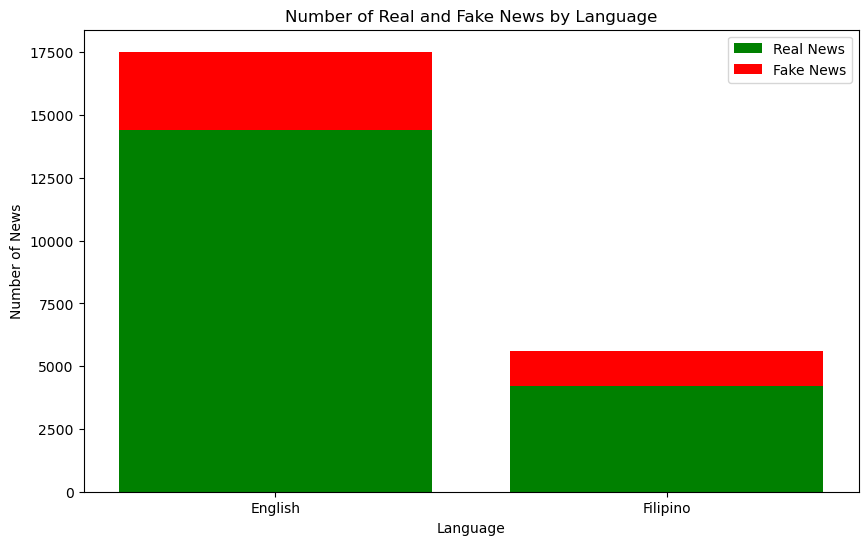

In [93]:
# bar plot to visualize the counts
languages = ['English', 'Filipino']
real_counts = [english_real_count, filipino_real_count]
fake_counts = [english_fake_count, filipino_fake_count]

plt.figure(figsize=(10, 6))
plt.bar(languages, real_counts, color='green', label='Real News')
plt.bar(languages, fake_counts, bottom=real_counts, color='red', label='Fake News')
plt.xlabel('Language')
plt.ylabel('Number of News')
plt.title('Number of Real and Fake News by Language')
plt.legend()
plt.show()

#### Figure 7. Number of Real and Fake News by Language

Based on the provided counts, English has the highest number of both real and fake news labels. There are 14,419 real news articles and 3,107 fake news articles written in English. However, it's important to note that we have more English articles in the dataset compared to Filipino articles, which may skew the results. 

## Feature Engineering

## Modeling

## Conclusion

## References



- Sharanya. (2021). Fake news detection. Kaggle. https://www.kaggle.com/code/sharanya02/fake-news-detection
